In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

import torch_geometric
print(torch_geometric.__version__)

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 4.1 MB/s 
     |████████████████████████████████| 3.5 MB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 3.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=074e43d3d24069297b2c77d578620eb68c5ae67698b490976c2b69152084666c
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
2.1.0


In [ ]:
!pip install gensim==3.8.3
from gensim.models import Word2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 17.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# Node2Vec
!pip install -U node2vec
from node2vec import Node2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=967cd2782e46661e8546a34c78771b25d6f037aaad948f5a0c4accbcc93bf0d1
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
edges = pd.read_csv('/content/graph_data.csv')

In [ ]:
G = nx.from_pandas_edgelist(edges, source="Source", target="Target",  edge_attr='Weight')
nx.info(G)

'Graph with 200 nodes and 16726 edges'

In [ ]:
degree_cent = nx.degree_centrality(G)
bet = nx.betweenness_centrality(G)
pgr=nx.pagerank(G)
lclu = nx.clustering(G)

In [ ]:
# take a random sample of edges

proportion_edges = 0.25
edge_subset = random.sample(G.edges(), int(proportion_edges * G.order()))

# the goal is to try and repredict these edges, and measure how close the prediction is to the original
# this is the equivalent of splitting into train and test set for link prediction

g_train = G.copy()
g_train.remove_edges_from(edge_subset)

In [ ]:
N,K = g_train.order(), g_train.size()

In [ ]:
edge_subset_size = len(list(edge_subset))
print("Deleted edges =", str(edge_subset_size))
print("Remaining edges =", str(K - edge_subset_size))

Deleted edges = 50
Remaining edges = 16626


Jaccard

In [ ]:
prediction_jaccard = list(nx.jaccard_coefficient(g_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_jaccard])

In [ ]:
score_jaccard[:10]

(0.7627118644067796,
 0.6931818181818182,
 0.6612903225806451,
 0.5178571428571429,
 0.5324675324675324,
 0.7142857142857143,
 0.7336956521739131,
 0.7379679144385026,
 0.7287234042553191,
 0.7336956521739131)

In [ ]:
label_jaccard[:10]

(False, False, False, False, False, False, False, False, False, False)

In [ ]:
fpr_jaccard, tpr_jaccard, thresholds_jaccard = roc_curve(label_jaccard, score_jaccard)
auc_jaccard = roc_auc_score(label_jaccard, score_jaccard)

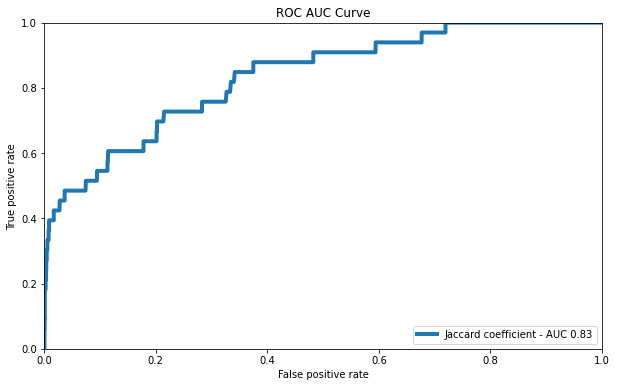

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_jaccard, tpr_jaccard, label='Jaccard coefficient - AUC %.2f' % auc_jaccard, linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC AUC Curve")
plt.legend(loc='lower right')
plt.show()

Adamic Adar Similarity

In [ ]:
prediction_adamic = list(nx.adamic_adar_index(g_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_adamic])

In [ ]:
fpr_adamic, tpr_adamic, thresholds_adamic = roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)

Pref Attachment method

In [ ]:
prediction_pref = list(nx.preferential_attachment(g_train))
score_pref , label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_pref])

In [ ]:
fpr_pref, tpr_pref, thresholds_pref = roc_curve(label_pref, score_pref)
auc_pref = roc_auc_score(label_pref, score_pref)

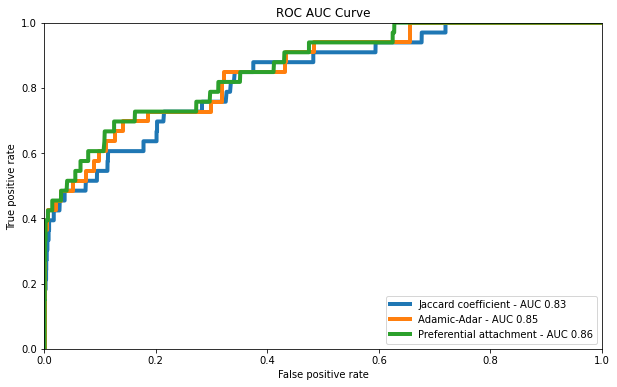

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_jaccard, tpr_jaccard, label='Jaccard coefficient - AUC %.2f' % auc_jaccard, linewidth=4)
plt.plot(fpr_adamic, tpr_adamic, label='Adamic-Adar - AUC %.2f' % auc_adamic, linewidth=4)
plt.plot(fpr_pref, tpr_pref, label='Preferential attachment - AUC %.2f' % auc_pref, linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC AUC Curve")
plt.legend(loc='lower right')
plt.show()

In [ ]:
optimal_idx = np.argmax(tpr_pref - fpr_pref)
optimal_threshold = thresholds_pref[optimal_idx]
print("Optimal threshold =", optimal_threshold)

Optimal threshold = 27528


GNN

In [ ]:
# retrieve the labels for each node
G1 = G.copy()
nx.set_node_attributes(G1, degree_cent, "degree_centrality")
nx.set_node_attributes(G1, pgr, "pagerank_centrality")
nx.set_node_attributes(G1, bet, "betweenness_centrality")
nx.set_node_attributes(G1, lclu, "local_clustering_coeff")

# labels = G1.nodes(data=True)

# create edge index from 
adj = nx.to_scipy_sparse_matrix(G1).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# using degree as embedding
embeddings = np.array(list(dict(G1.degree()).values()))

# normalizing degree values
scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))

In [ ]:
# Precompute probabilities and generate walks
n2v = Node2Vec(G1, dimensions=16, walk_length=20, num_walks=100, workers=4)

# Embed nodes
n2v_model = n2v.fit(window=4, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
index_map = np.zeros(len(G1.nodes()), dtype='int64')
index_map = np.array(list(range(0,G1.number_of_nodes())))
nodes = list(G1.nodes())
index_map

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
node_embeddings = n2v_model.wv.vectors[index_map]

In [ ]:
PG_G = from_networkx(G1)

In [ ]:
PG_G

Data(edge_index=[2, 33304], degree_centrality=[200], pagerank_centrality=[200], betweenness_centrality=[200], local_clustering_coeff=[200], Weight=[33304], num_nodes=200)

In [ ]:
arr = np.array(PG_G.Weight)
arr

array(["{'weight': 1.0}", "{'weight': 1.0}", "{'weight': 1.0}", ...,
       "{'weight': 1.0}", "{'weight': 1.0}", "{'weight': 1.0}"],
      dtype='<U15')

In [ ]:
weight_arr = arr.reshape(-1,1)

x = torch.tensor(node_embeddings)
x = torch.cat((x, PG_G.degree_centrality.reshape(-1,1), PG_G.betweenness_centrality.reshape(-1,1), PG_G.pagerank_centrality.reshape(-1,1), PG_G.local_clustering_coeff.reshape(-1,1)), dim = 1)
x.shape

torch.Size([200, 20])

In [ ]:
# import tensorflow as tf
# weight_arr = tf.convert_to_tensor(weight_arr, dtype=tf.float32)
# # weight_arr.tolist()


In [ ]:
data = Data(x = x, edge_index = PG_G.edge_index, y = torch.ones(PG_G.num_edges)).to(device, non_blocking=True)
data

Data(x=[200, 20], edge_index=[2, 33304], y=[33304])

In [ ]:
data_list = [PG_G]
loader = DataLoader(data_list)

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv
import torch_geometric
from torch_geometric.utils import negative_sampling
import itertools
import torch.nn.functional as F

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),])
train_data, val_data, test_data = transform(data)

In [ ]:
class Predictor(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.W1 = torch.nn.Linear(out_channels *2, 64) 
        self.W2 = torch.nn.Linear(64, 1)
    
    def forward(self, node_feature1, node_feature2):

        node_feature_cat = torch.cat((node_feature1, node_feature2), 1)
        x = node_feature_cat

        temp = F.relu(self.W1(x).squeeze(1))
        temp = F.dropout(temp, p=0.5)
        temp = self.W2(temp)
        return temp.squeeze(1)

In [ ]:
class GNNet(torch.nn.Module):
    def __init__(self, Conv_layer, in_channels, hidden_channels, out_channels, aggr):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, aggr=aggr)
        self.conv2 = GCNConv(hidden_channels, out_channels, aggr=aggr)

        self.pred = Predictor(out_channels)

    def encode(self, x, edge_index, **kwargs):
        x = self.conv1(x, edge_index, **kwargs).relu()
        return self.conv2(x, edge_index, **kwargs)

    def decode(self, z, edge_label_index):
        return self.pred.forward(z[edge_label_index[0]], z[edge_label_index[1]])

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1,)
    edge_label = torch.cat([train_data.edge_label,train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
@torch.no_grad()
def test(data, model):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

GCN(Graph Convolutional Networks)- It is a Propogation Model, more specifically a Spectral method.

In [ ]:
#Model for GCN
model = GNNet(GCNConv, data.num_features, 64, 32, 'add').to(device)

optimizer = torch.optim.Adam(params=itertools.chain(model.parameters(), model.pred.parameters()), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

/usr/local/lib/python3.7/dist-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [ ]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 301):
    loss = train(model, optimizer)
    val_auc = test(val_data, model)
    test_auc = test(test_data, model)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, '
          f'Test AUC: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6940, Val AUC: 0.5363, Test AUC: 0.5271
Epoch: 002, Loss: 0.6876, Val AUC: 0.5661, Test AUC: 0.5459
Epoch: 003, Loss: 0.6907, Val AUC: 0.5571, Test AUC: 0.5589
Epoch: 004, Loss: 0.6872, Val AUC: 0.5258, Test AUC: 0.5251
Epoch: 005, Loss: 0.6890, Val AUC: 0.5330, Test AUC: 0.5201
Epoch: 006, Loss: 0.6895, Val AUC: 0.5230, Test AUC: 0.5295
Epoch: 007, Loss: 0.6876, Val AUC: 0.5538, Test AUC: 0.5569
Epoch: 008, Loss: 0.6863, Val AUC: 0.5805, Test AUC: 0.5628
Epoch: 009, Loss: 0.6867, Val AUC: 0.5956, Test AUC: 0.5775
Epoch: 010, Loss: 0.6871, Val AUC: 0.5716, Test AUC: 0.5826
Epoch: 011, Loss: 0.6858, Val AUC: 0.5630, Test AUC: 0.5650
Epoch: 012, Loss: 0.6855, Val AUC: 0.6215, Test AUC: 0.6053
Epoch: 013, Loss: 0.6856, Val AUC: 0.6220, Test AUC: 0.6224
Epoch: 014, Loss: 0.6850, Val AUC: 0.6571, Test AUC: 0.6359
Epoch: 015, Loss: 0.6840, Val AUC: 0.6595, Test AUC: 0.6367
Epoch: 016, Loss: 0.6827, Val AUC: 0.6440, Test AUC: 0.6465
Epoch: 017, Loss: 0.6832, Val AUC: 0.690

GraphSage

In [ ]:
model_sage = GNNet(SAGEConv, data.num_features, 64, 16, 'add').to(device)
optimizer_sage = torch.optim.Adam(params=itertools.chain(model_sage.parameters(), model_sage.pred.parameters()), lr=0.01)
criterion_sage = torch.nn.BCEWithLogitsLoss()

/usr/local/lib/python3.7/dist-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [ ]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 301):
    loss = train(model_sage, optimizer)
    val_auc = test(val_data, model)
    test_auc = test(test_data, model)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, '
          f'Test AUC: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6985, Val AUC: 0.8673, Test AUC: 0.8655
Epoch: 002, Loss: 0.6985, Val AUC: 0.8624, Test AUC: 0.8572
Epoch: 003, Loss: 0.6986, Val AUC: 0.8548, Test AUC: 0.8449
Epoch: 004, Loss: 0.6986, Val AUC: 0.8529, Test AUC: 0.8440
Epoch: 005, Loss: 0.6985, Val AUC: 0.8430, Test AUC: 0.8333
Epoch: 006, Loss: 0.6984, Val AUC: 0.8352, Test AUC: 0.8275
Epoch: 007, Loss: 0.6984, Val AUC: 0.8176, Test AUC: 0.8168
Epoch: 008, Loss: 0.6984, Val AUC: 0.8232, Test AUC: 0.8230
Epoch: 009, Loss: 0.6985, Val AUC: 0.8153, Test AUC: 0.8128
Epoch: 010, Loss: 0.6982, Val AUC: 0.8006, Test AUC: 0.8113
Epoch: 011, Loss: 0.6985, Val AUC: 0.7933, Test AUC: 0.8029
Epoch: 012, Loss: 0.6984, Val AUC: 0.8036, Test AUC: 0.7951
Epoch: 013, Loss: 0.6983, Val AUC: 0.8113, Test AUC: 0.7887
Epoch: 014, Loss: 0.6985, Val AUC: 0.7918, Test AUC: 0.7915
Epoch: 015, Loss: 0.6986, Val AUC: 0.7847, Test AUC: 0.7869
Epoch: 016, Loss: 0.6985, Val AUC: 0.7800, Test AUC: 0.7806
Epoch: 017, Loss: 0.6985, Val AUC: 0.783